In [38]:
import pandas as pd
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
import matplotlib.font_manager as fm
import matplotlib
# 디렉토리 및 파일 이름에 맞추어 변경
font_location = 'C:\\Windows\\Fonts\\malgun.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

In [149]:
import geopandas as gpd
import pandas as pd
districts =  gpd.read_file(r"C:\Users\Anichan\Documents\공부자료\24.03 광진구청 공모전\code\서울_행정동_경계_2017.geojson")
districts_gdf = districts[districts['adm_nm'].str.contains('광진구', na=False)] # 광진구 행정동 경계 데이터

# 격자 추가하기

# import geopandas as gpd
# import pandas as pd
# districts =  gpd.read_file("./code/서울행정동_경계_2017.geojson")
# districts_gdf = districts[districts['adm_nm'].str.contains('광진구', na=False)] # 광진구 행정동 경계 데이터

# folium.GeoJson(
#     districts_gdf,
#     name="행정동 경계",
#     style_function=lambda feature: {"fillColor": "gray", "color": "black", "weight": 1, "fillOpacity": 0.2},
#     tooltip=folium.GeoJsonTooltip(fields=["adm_nm"], aliases=["행정동"]),  # 컬럼명 수정
# ).add_to(m)

# 클러스터링

C:\Users\Anichan\AppData\Local\Temp\ipykernel_18828\1027915068.py:46: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].clip(upper=max_threshold)
C:\Users\Anichan\AppData\Local\Temp\ipykernel_18828\1027915068.py:46: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].cl

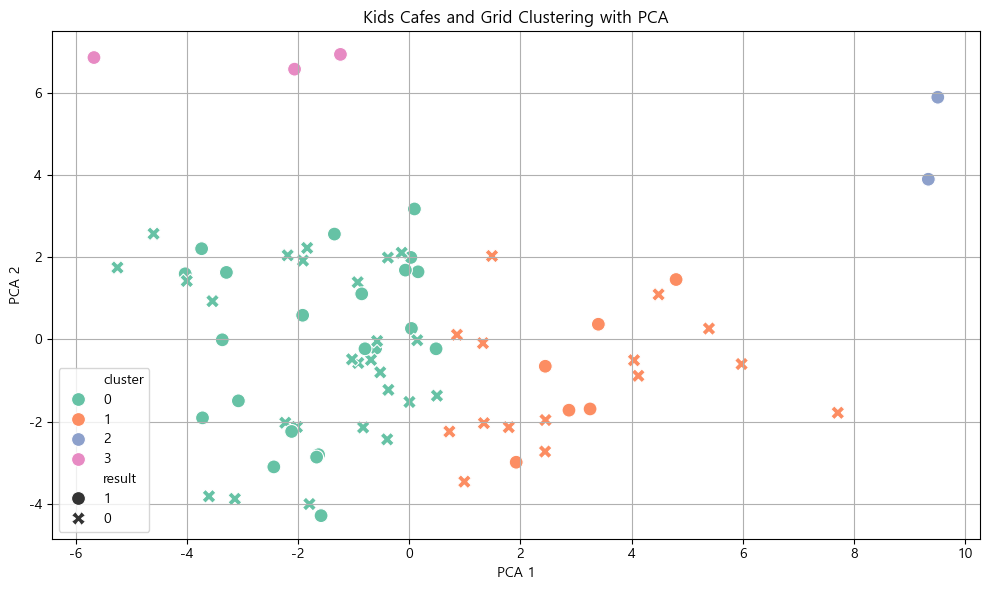

각 군집별 예약률 80% 이상인 키즈카페 개수:
cluster
0    22
1     6
2     2
3     3
Name: result, dtype: object


In [96]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# *********************************
n = 4 # 군집 개수 설정
# *********************************


# ---------------------------------------
# 1. 데이터 로드 및 전처리
# ---------------------------------------
# 키즈카페 원본 CSV 불러오기
kids_df = pd.read_csv('data/최종csv/result1000-80.csv', encoding='cp949')
grid_df = pd.read_csv('data/최종csv/gwangjin_1000m_all.csv', encoding='cp949')

# 공통 컬럼 추출
common_columns = [
    'longitude', 'latitude',
    '유흥주점_개수', '유흥주점_최소거리(m)', '단란주점_개수', '단란주점_최소거리(m)',
    '유치원_개수', '유치원_최소거리(m)', '버스_개수', '버스_최소거리(m)', '공원_개수', '공원_최소거리(m)',
    '대형마트_개수', '대형마트_최소거리(m)', '편의점_개수', '편의점_최소거리(m)', '어린이집_개수',
    '어린이집_최소거리(m)', '학교_개수', '학교_최소거리(m)', '학원_개수', '학원_최소거리(m)', '주차장_개수',
    '주차장_최소거리(m)', '주유소_개수', '주유소_최소거리(m)', '지하철역_개수', '지하철역_최소거리(m)',
    '은행_개수', '은행_최소거리(m)', '문화시설_개수', '문화시설_최소거리(m)', '중개업소_개수', '중개업소_최소거리(m)',
    '공공기관_개수', '공공기관_최소거리(m)', '관광명소_개수', '관광명소_최소거리(m)', '숙박_개수', '숙박_최소거리(m)',
    '음식점_개수', '음식점_최소거리(m)', '카페_개수', '카페_최소거리(m)', '병원_개수', '병원_최소거리(m)',
    '약국_개수', '약국_최소거리(m)', '비활동시간_평일', '활동시간_평일', '비활동시간_휴일', '활동시간_휴일',
    '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원', '사설키즈_개수', '사설키즈_최소거리(m)'
    # ,'이용정원_개인', '이용정원_단체'
]

# common_columns = selected_columns.tolist()

# 데이터 준비
kids_clean = kids_df[common_columns].copy()
grid_clean = grid_df[common_columns].copy()

# 거리 피처 클리핑
distance_cols = [col for col in common_columns if '거리' in col]
for df in [kids_clean, grid_clean]:
    for col in distance_cols:
        max_threshold = df[col].replace(99999, pd.NA).dropna().quantile(0.95)
        df[col] = df[col].clip(upper=max_threshold)
        df[col] = df[col].replace(99999, max_threshold)

# 정규화
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_distance = MinMaxScaler()
scaler_count = StandardScaler()

count_cols = [col for col in common_columns if '개수' in col and col not in distance_cols]
demo_cols = ['비활동시간_평일', '활동시간_평일', '비활동시간_휴일', '활동시간_휴일', '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원']
# kids_cols = ['이용정원_개인', '이용정원_단체']
kids_scaled = kids_clean.copy()
grid_scaled = grid_clean.copy()

# 거리: MinMax
kids_scaled[distance_cols] = scaler_distance.fit_transform(kids_clean[distance_cols])
grid_scaled[distance_cols] = scaler_distance.fit_transform(grid_clean[distance_cols])

# 개수: Standard
kids_scaled[count_cols] = scaler_count.fit_transform(kids_clean[count_cols])
grid_scaled[count_cols] = scaler_count.fit_transform(grid_clean[count_cols])

# 인구 관련: Standard
kids_scaled[demo_cols] = scaler_count.fit_transform(kids_clean[demo_cols])
grid_scaled[demo_cols] = scaler_count.fit_transform(grid_clean[demo_cols])

# 병합
# combined_scaled = pd.concat([kids_scaled, grid_scaled], ignore_index=True)

combined_scaled = kids_scaled[demo_cols + count_cols].copy()

# ---------------------------------------
# 2. PCA 차원 축소 (2D)
# ---------------------------------------
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(combined_scaled)

# ---------------------------------------
# 3. KMeans 클러스터링
# ---------------------------------------
kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(reduced)

# 병합된 데이터에 'cluster' 컬럼 추가
combined_scaled['cluster'] = clusters

# # 키즈카페에 'result' 추가
combined_scaled['result'] = None
combined_scaled.loc[:len(kids_df)-1, 'result'] = kids_df['result'].values

# ---------------------------------------
# 4. 시각화 (PCA 결과로 클러스터링 시각화)
# ---------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced[:, 0], 
    y=reduced[:, 1], 
    hue=combined_scaled['cluster'], 
    palette='Set2', 
    s=100,
    style=combined_scaled['result'].map({0: '0', 1: '1'}),  # 예약률 80% 이상 표시
)
plt.title("Kids Cafes and Grid Clustering with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 5. 각 군집별 result == 1의 개수 출력
# ---------------------------------------
cluster_result_count = combined_scaled.groupby('cluster')['result'].sum()
print("각 군집별 예약률 80% 이상인 키즈카페 개수:")
print(cluster_result_count)


In [15]:
name = kids_df['키즈카페 이름'].copy()
combined_scaled['키즈카페 이름'] = name

In [19]:
combined_scaled[combined_scaled['cluster'] == 2]['키즈카페 이름']

0                   서울형키즈카페강남구역삼1동점
42    서울형키즈카페서초구서초1동점(서리풀노리학교서초1동점)
Name: 키즈카페 이름, dtype: object

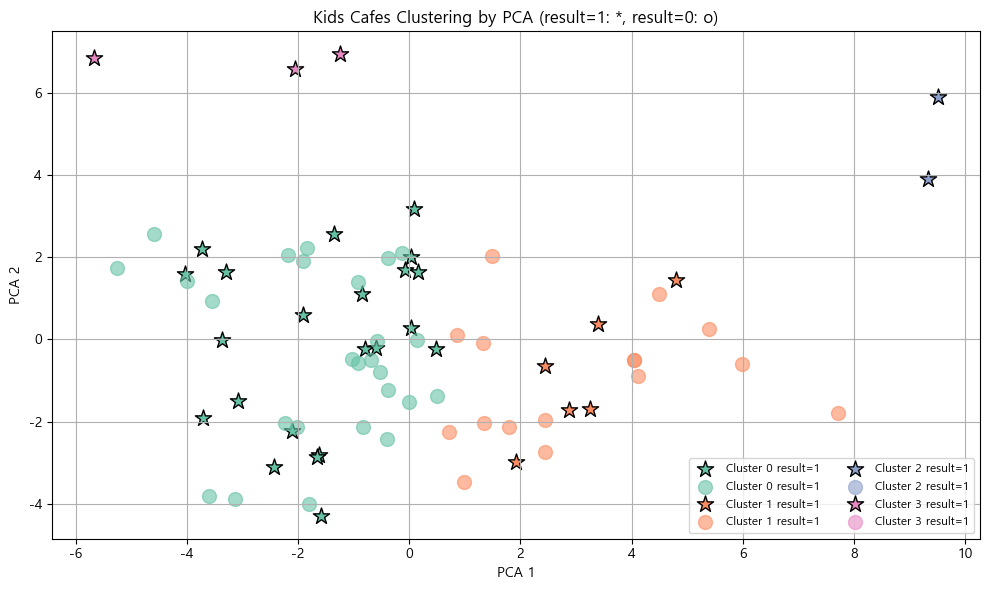

In [168]:
import matplotlib.pyplot as plt

# 색상 팔레트
palette = sns.color_palette('Set2', n_colors=n)

# 클러스터 시각화
plt.figure(figsize=(10, 6))
for cluster_id in sorted(combined_scaled['cluster'].unique()):
    cluster_mask = (combined_scaled['cluster'] == cluster_id)

    # 클러스터 내 result=1 (예약률 80% 이상)
    high_mask = cluster_mask & (combined_scaled['result'] == 1)
    plt.scatter(
        reduced[high_mask, 0],
        reduced[high_mask, 1],
        c=[palette[cluster_id]],
        label=f'Cluster {cluster_id} result=1',
        marker='*',
        s=150,
        edgecolor='black'
    )

    # 클러스터 내 result=0
    low_mask = cluster_mask & (combined_scaled['result'] == 0)
    plt.scatter(
        reduced[low_mask, 0],
        reduced[low_mask, 1],
        c=[palette[cluster_id]],
        label=f'Cluster {cluster_id} result=1',
        marker='o',
        s=100,
        alpha=0.6
    )

plt.title("Kids Cafes Clustering by PCA (result=1: *, result=0: o)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend(loc='best', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


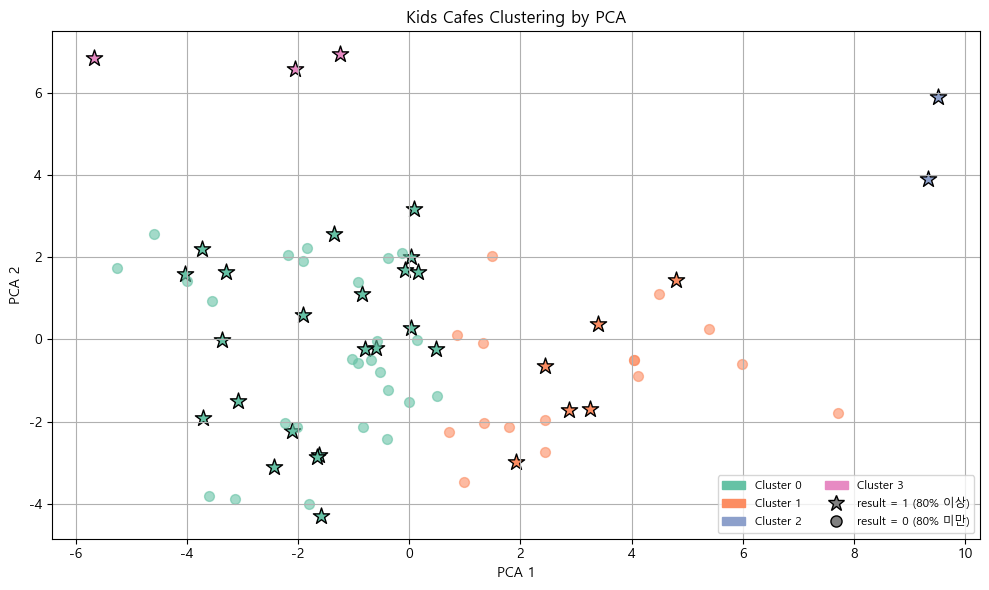

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 색상 팔레트
palette = sns.color_palette('Set2', n_colors=n)

plt.figure(figsize=(10, 6))

# 군집별로 반복
for cluster_id in sorted(combined_scaled['cluster'].unique()):
    cluster_mask = (combined_scaled['cluster'] == cluster_id)

    # result = 1 (예약률 80% 이상)
    high_mask = cluster_mask & (combined_scaled['result'] == 1)
    plt.scatter(
        reduced[high_mask, 0],
        reduced[high_mask, 1],
        c=[palette[cluster_id]],
        marker='*',
        s=150,
        edgecolor='black'
    )

    # result = 0 (예약률 80% 미만)
    low_mask = cluster_mask & (combined_scaled['result'] == 0)
    plt.scatter(
        reduced[low_mask, 0],
        reduced[low_mask, 1],
        c=[palette[cluster_id]],
        marker='o',
        s=50,
        alpha=0.6
    )

# 커스텀 범례 생성
legend_elements = [
    mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(n)
] + [
    plt.Line2D([0], [0], marker='*', color='w', label='result = 1 (80% 이상)',
               markerfacecolor='gray', markeredgecolor='black', markersize=12),
    plt.Line2D([0], [0], marker='o', color='w', label='result = 0 (80% 미만)',
               markerfacecolor='gray', markeredgecolor='black', markersize=8),
]

# 오른쪽 아래에 레전드 배치
plt.legend(handles=legend_elements, loc='lower right', fontsize='small', ncol=2)

plt.title("Kids Cafes Clustering by PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [169]:
combined_scaled.groupby('cluster')['result'].value_counts()

cluster  result
0        0         26
         1         22
1        0         16
         1          6
2        1          2
3        1          3
Name: count, dtype: int64

In [170]:
combined_scaled['cluster'].value_counts()

cluster
0    48
1    22
3     3
2     2
Name: count, dtype: int64

## 최적의 군집 수 착기 (엘보우, 실루엣 점수)

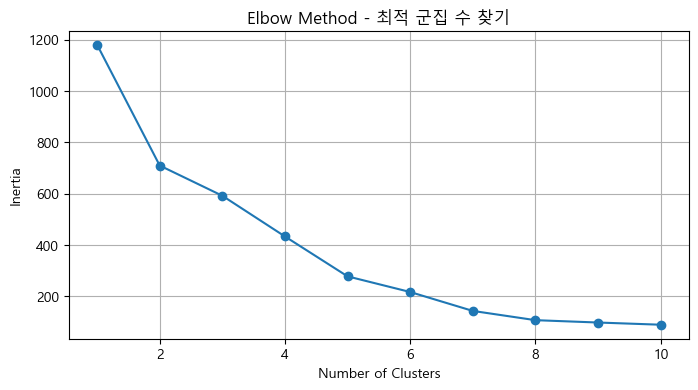

In [171]:
inertia_list = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(reduced)
    inertia_list.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia_list, marker='o')
plt.title('Elbow Method - 최적 군집 수 찾기')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


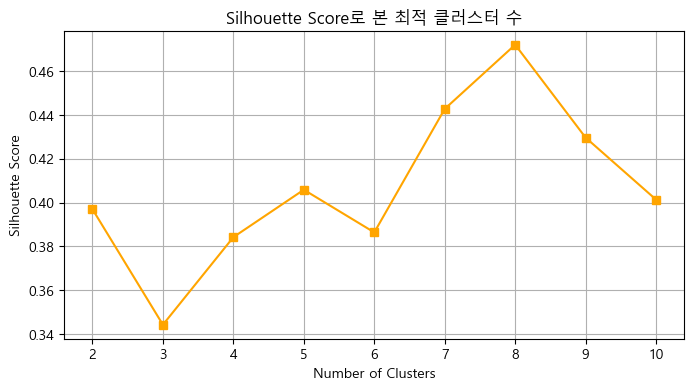

In [172]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 11):  # silhouette는 k=1일 땐 정의되지 않음
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    preds = km.fit_predict(reduced)
    score = silhouette_score(reduced, preds)
    sil_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), sil_scores, marker='s', color='orange')
plt.title("Silhouette Score로 본 최적 클러스터 수")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


## Feature Importance 시각화

C:\Users\Anichan\AppData\Local\Temp\ipykernel_2436\2308784678.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (loadings['PC1'][i], loadings['PC2'][i]), fontsize=9)


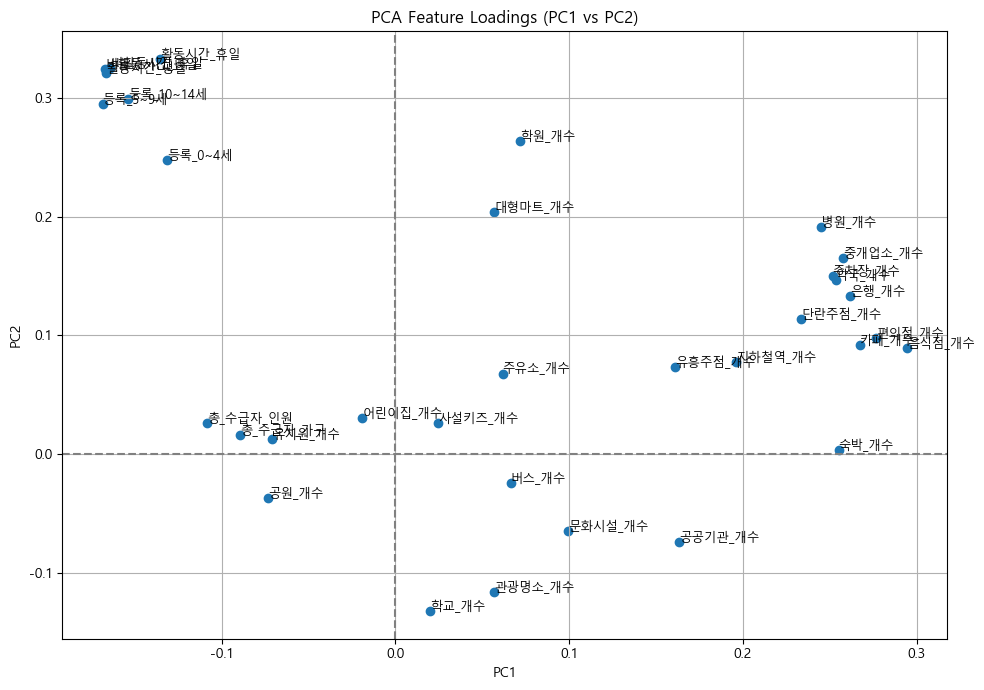

In [173]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(combined_scaled[count_cols + demo_cols])

# Loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=combined_scaled[count_cols + demo_cols].columns)

# 시각화
plt.figure(figsize=(10, 7))
plt.scatter(loadings['PC1'], loadings['PC2'])

for i, txt in enumerate(loadings.index):
    plt.annotate(txt, (loadings['PC1'][i], loadings['PC2'][i]), fontsize=9)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title('PCA Feature Loadings (PC1 vs PC2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()


## 클러스터링 시각화 및 군집 특성 보기

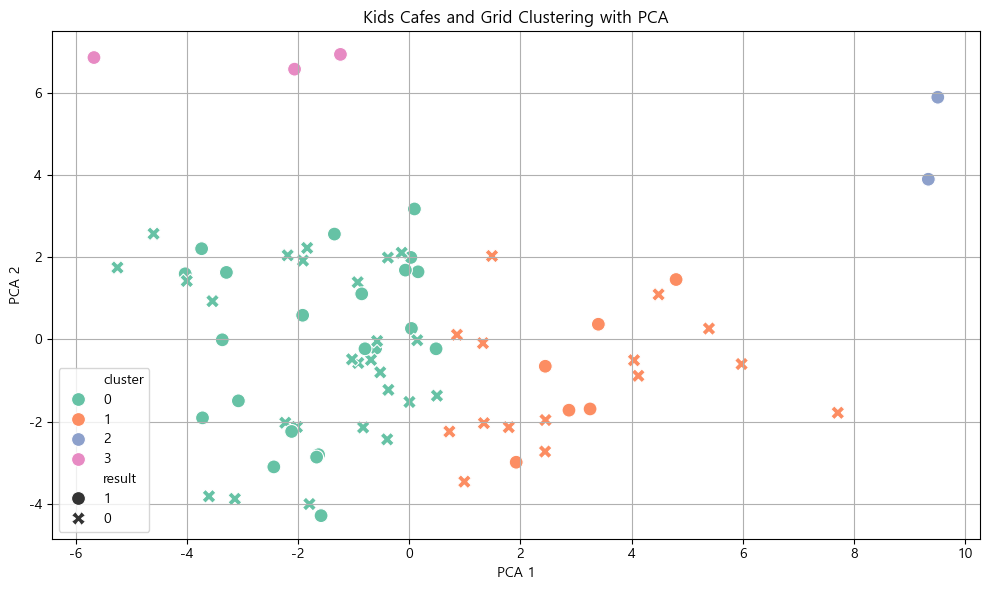

각 군집별 예약률 80% 이상인 키즈카페 개수:
cluster
0    22
1     6
2     2
3     3
Name: result, dtype: int64


In [174]:
# 키즈카페에 'result' 추가
combined_scaled['result'] = None
combined_scaled.loc[:len(kids_df)-1, 'result'] = kids_df['result'].values
combined_scaled.fillna(2, inplace=True)  # NaN을 2로 대체
combined_scaled['result'] = combined_scaled['result'].astype(int)

# ---------------------------------------
# 4. 시각화 (PCA 결과로 클러스터링 시각화)
# ---------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced[:, 0], 
    y=reduced[:, 1], 
    hue=combined_scaled['cluster'], 
    palette='Set2', 
    s=100,
    style=combined_scaled['result'].map({0: '0', 1: '1', 2:'2'}),  # 예약률 80% 이상 표시
)
plt.title("Kids Cafes and Grid Clustering with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# 5. 각 군집별 result == 1의 개수 출력
# ---------------------------------------
cluster_result_count = combined_scaled[combined_scaled['result'] == 1].groupby('cluster')['result'].count()
print("각 군집별 예약률 80% 이상인 키즈카페 개수:")
print(cluster_result_count)

In [175]:
# 군집별 0과 1의 개수
combined_scaled.groupby('cluster')['result'].value_counts()

cluster  result
0        0         26
         1         22
1        0         16
         1          6
2        1          2
3        1          3
Name: count, dtype: int64

In [176]:
# 군집별 데이터 개수
combined_scaled['cluster'].value_counts()

cluster
0    48
1    22
3     3
2     2
Name: count, dtype: int64

In [97]:
# 군집별 변수 평균 값 원래의 단위로 (스케일 값x)
kids_clean_clustered = kids_clean[count_cols + demo_cols].copy()
kids_clean_clustered['cluster'] = clusters
cluster_raw_summary = kids_clean_clustered.groupby('cluster').mean().round(2)
cluster_raw_summary.T  # 보기 쉽게 transpose


cluster,0,1,2,3
유흥주점_개수,4.15,12.55,45.00,0.67
단란주점_개수,7.90,17.59,45.50,12.00
유치원_개수,5.96,5.45,2.50,5.67
버스_개수,84.90,90.73,81.00,65.67
공원_개수,0.88,0.68,0.00,1.00
대형마트_개수,3.46,3.27,6.50,5.00
편의점_개수,54.62,84.41,136.50,59.67
어린이집_개수,39.04,35.91,20.00,21.67
학교_개수,9.79,12.09,5.50,8.33
학원_개수,199.81,227.45,430.50,414.67


In [100]:
kids_clean_clustered

,유흥주점_개수,단란주점_개수,유치원_개수,버스_개수,공원_개수,대형마트_개수,편의점_개수,어린이집_개수,학교_개수,학원_개수,...,비활동시간_평일,활동시간_평일,비활동시간_휴일,활동시간_휴일,등록_0~4세,등록_5~9세,등록_10~14세,총_수급자_가구,총_수급자_인원,cluster
0,60,55,2,52,0,3,148,17,3,261,...,1013.440693,1147.103637,1142.400354,1982.192057,413,360,521,929,1104,2
1,0,0,6,69,2,3,34,37,12,280,...,1847.179492,2041.734571,1837.679862,1722.329091,1009,1584,1636,447,582,0
2,0,0,4,40,0,4,42,51,7,244,...,3177.168825,2911.404363,3084.725913,2762.576470,558,676,744,646,1020,0
3,0,0,8,70,1,2,34,55,10,206,...,3177.168825,2911.404363,3084.725913,2762.576470,558,676,744,646,1020,0
4,1,10,4,60,1,5,68,40,10,196,...,1393.086654,1514.078584,1353.269921,1279.025767,518,622,743,269,388,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,28,21,9,68,0,5,75,59,8,334,...,1748.668870,1525.339326,1697.490388,1565.171357,815,1044,1235,1213,1634,0
71,3,11,3,73,0,1,84,20,7,101,...,993.730997,1031.462468,990.399628,1016.444668,337,358,480,1314,1564,1
72,6,8,6,62,0,1,87,29,16,112,...,551.139371,840.407002,533.071645,507.400788,111,168,287,259,322,1
73,1,26,9,103,1,4,77,56,9,256,...,1903.940961,1760.920230,1942.636648,1875.261565,514,752,1055,1936,2572,0


In [101]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = kids_clean_clustered.copy()

# 1. feature 선택 (거리 컬럼 제외)
feature_cols = [
    col for col in df.columns 
    if col not in ['gid', 'longitude', 'latitude', 'geometry', 'centroid', 
                   'adm_cd', '행자부행정동코드', '시군구명', '행정동', 'cluster']
    and '거리' not in col  # '거리' 들어간 컬럼 제외
]

X = df[feature_cols].copy()
cluster = df['cluster']
# longitude = df['longitude']
# latitude = df['latitude']

# 2. 정규화
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

X_scaled['cluster'] = cluster
# X_scaled['longitude'] = longitude
# X_scaled['latitude'] = latitude
cluster_mean = X_scaled.groupby('cluster').mean()

# 4. 컬럼 카테고리 매핑 (거리 제외 기준으로 수정)
categories = {
    '편의시설': [
        '대형마트_개수', '편의점_개수', '은행_개수', '문화시설_개수', '숙박_개수',
        '음식점_개수', '카페_개수', '공원_개수', '공공기관_개수', '관광명소_개수', '중개업소_개수', '약국_개수', '병원_개수'
    ],
    '교육시설': [
        '어린이집_개수', '학교_개수', '학원_개수', '유치원_개수'
    ],
    '기피시설': [
        '유흥주점_개수', '단란주점_개수', '사설키즈_개수'
    ],
    '교통시설': [
        '버스_개수', '지하철역_개수', '주차장_개수', '주유소_개수'
    ],
    '인구': [
         '비활동시간_휴일', '활동시간_휴일',
        '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원'
        # ,'비활동시간_평일', '활동시간_평일'
        # , 'R_HD_A00_24_mean'
    ]
}

# 5. 카테고리별 평균 스코어 계산
category_scores = pd.DataFrame(index=cluster_mean.index)

for category, cols in categories.items():
    valid_cols = [col for col in cols if col in cluster_mean.columns]
    category_scores[category] = cluster_mean[valid_cols].mean(axis=1)

# 6. 전체 스코어 계산 (필요하면 가중합 가능)
category_scores['기피시설'] = -category_scores['기피시설']
category_scores['Total_Score'] = category_scores.mean(axis=1)


In [103]:
category_scores.to_csv('data/최종csv/4_cluster_summary_kids.csv', encoding='cp949')

In [95]:
for category, cols in categories.items():
    valid_cols = [col for col in cols if col in cluster_mean.columns]
    print(category)
    for i in valid_cols:
        print(i, end=', ')

    print('---------')

편의시설
대형마트_개수, 편의점_개수, 은행_개수, 문화시설_개수, 숙박_개수, 음식점_개수, 카페_개수, 공원_개수, 공공기관_개수, 관광명소_개수, 중개업소_개수, 약국_개수, 병원_개수, ---------
교육시설
어린이집_개수, 학교_개수, 학원_개수, 유치원_개수, ---------
기피시설
유흥주점_개수, 단란주점_개수, 사설키즈_개수, ---------
교통시설
버스_개수, 지하철역_개수, 주차장_개수, 주유소_개수, ---------
인구
비활동시간_휴일, 활동시간_휴일, 등록_0~4세, 등록_5~9세, 등록_10~14세, 총_수급자_가구, 총_수급자_인원, ---------


In [206]:
category_scores

,편의시설,교육시설,기피시설,교통시설,인구,Total_Score
cluster,,,,,,
0,0.206469,0.391421,-0.151877,0.267931,0.335922,1.049867
1,0.382649,0.407860,-0.233740,0.387755,0.165918,1.110442
2,0.619979,0.268893,-0.461472,0.592447,0.238517,1.258364
3,0.268585,0.378918,-0.130046,0.398028,0.642305,1.557789


In [178]:
# 군집별 변수 평균 값 원래의 단위로 (스케일 값x)
kids_clean_clustered = kids_clean[count_cols + demo_cols].copy()
kids_clean_clustered['cluster'] = clusters
cluster_raw_summary = kids_clean_clustered.groupby('cluster').mean().round(2)
a = cluster_raw_summary.T  # 보기 쉽게 transpose

a.to_csv('data/최종csv/4_cluster_summary.csv', encoding='cp949')

In [36]:
# 군집별 변수 평균 값 원래의 단위로 (스케일 값x)
kids_clean_clustered = kids_clean[count_cols + demo_cols].copy()
kids_clean_clustered['cluster'] = clusters
cluster_raw_summary = kids_clean_clustered.groupby('cluster').mean().round(2)

In [37]:
cluster_raw_summary

,유흥주점_개수,단란주점_개수,유치원_개수,버스_개수,공원_개수,대형마트_개수,편의점_개수,어린이집_개수,학교_개수,학원_개수,...,사설키즈_개수,비활동시간_평일,활동시간_평일,비활동시간_휴일,활동시간_휴일,등록_0~4세,등록_5~9세,등록_10~14세,총_수급자_가구,총_수급자_인원
cluster,,,,,,,,,,,,,,,,,,,,,
0,9.00,12.19,5.65,86.73,0.89,3.35,65.32,37.49,10.89,213.54,...,3.08,1351.65,1358.25,1344.94,1332.73,494.00,633.32,801.59,910.16,1242.30
1,6.33,11.36,5.86,86.17,0.75,3.81,65.36,36.94,9.89,236.89,...,2.25,1430.11,1423.41,1395.74,1380.24,522.17,753.86,1010.50,803.61,1062.64
2,3.00,16.50,4.00,59.50,0.00,2.50,80.50,26.00,6.50,135.50,...,5.00,1016.42,1086.87,1168.45,1767.16,516.00,413.50,386.00,617.00,746.50


In [ ]:
# 5. 카테고리별 평균 스코어 계산
category_scores = pd.DataFrame(index=cluster_mean.index)

for category, cols in categories.items():
    valid_cols = [col for col in cols if col in cluster_mean.columns]
    category_scores[category] = cluster_mean[valid_cols].mean(axis=1)

## 키즈카페 데이터 군집별 시각화

In [179]:
kids_clean_clustered = kids_clean.copy()
kids_clean_clustered['cluster'] = clusters
kids_clean_clustered['result'] = kids_df['result'].values

In [ ]:
test = kids_df.copy()
test['cluster'] = clusters
test.to_csv('data/최종csv/test.csv', encoding='cp949', index=False)

In [180]:
import folium

# 지도 중심
map_center = [kids_clean['latitude'].mean(), kids_clean['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# 색상 팔레트
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen']

# 마커 직접 추가 (클러스터 사용 X)
for _, row in kids_clean_clustered.iterrows():
    cluster_num = int(row['cluster'])
    color = colors[cluster_num % len(colors)]
    
    # 예약률 80% 이상은 테두리 진한 CircleMarker로 표시
    if row['result'] == 1:
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=8,
            color='black',
            fill=True,
            fill_color=color,
            fill_opacity=0.9,
            popup=f"Cluster: {cluster_num} | 예약률 80% 이상",
        ).add_to(m)
    else:
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=6,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            popup=f"Cluster: {cluster_num} | 예약률 80% 미만",
        ).add_to(m)


# 지도 저장
m.save("kids_cafe_cluster_map.html")
m


# 학습한 모델을 광진구 데이터에 적용

In [12]:
len(grid_scaled[demo_cols + count_cols].columns)

33

In [45]:
# PCA 적용 (fit은 하지 않고 transform만)
grid_reduced = pca.transform(grid_scaled[demo_cols + count_cols])

# 클러스터 예측
grid_cluster = kmeans.predict(grid_reduced)

# 시각화용 데이터프레임
grid_plot_df = pd.DataFrame({
    'PCA1': grid_reduced[:, 0],
    'PCA2': grid_reduced[:, 1],
    'cluster': grid_cluster,
})


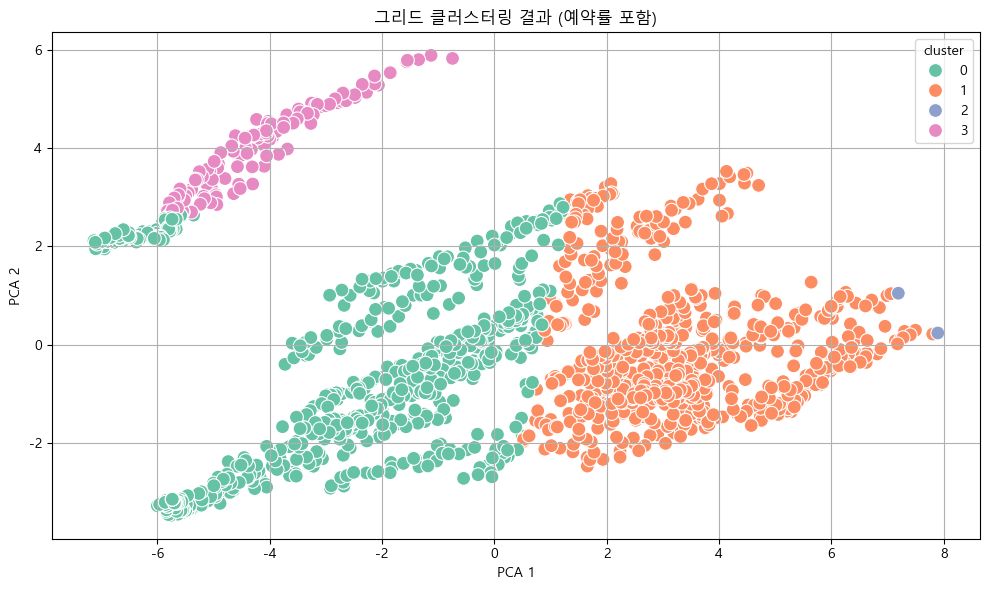

In [46]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=grid_plot_df,
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='Set2',
    s=100
)

plt.title("그리드 클러스터링 결과 (예약률 포함)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
import numpy as np
import pandas as pd

# 방법 1: numpy 사용
cluster_counts = np.bincount(grid_cluster)
for i, count in enumerate(cluster_counts):
    print(f"클러스터 {i}번: {count}개")

# 방법 2: pandas 사용 (더 유연하게 정렬, 시각화 등 가능)
pd.Series(grid_cluster).value_counts().sort_index()


클러스터 0번: 716개
클러스터 1번: 747개
클러스터 2번: 2개
클러스터 3번: 121개


0    716
1    747
2      2
3    121
Name: count, dtype: int64

In [187]:
import folium

# 중심 좌표
map_center = [grid_plot['latitude'].mean(), grid_plot['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# 색상 팔레트
colors = [ 'green' ,'red', 'blue', 'purple', 'orange', 'darkred', 'cadetblue', 'darkgreen']

# 마커 하나씩 직접 추가 (MarkerCluster 사용 X)
for _, row in grid_plot.iterrows():
    cluster_num = int(row['cluster'])
    color = colors[cluster_num % len(colors)]

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"Cluster: {cluster_num}"
    ).add_to(m)

m.save("gwangjin_cluster_map.html")
# 지도 출력
m


In [99]:
grid_df['cluster'] = grid_cluster
grid_df.to_csv('data/최종csv/gwangjin_clustered.csv', encoding='cp949', index=False)

# 광진구 군집 특성 보기

In [68]:
grid_df = pd.read_csv('data/최종csv/gwangjin_clustered.csv', encoding='cp949')
grid_clean = grid_df[common_columns].copy()

In [69]:
# 군집별 변수 평균 값 원래의 단위로 (스케일 값x)
grid_clean_clustered = grid_clean[count_cols + demo_cols].copy()
grid_clean_clustered['cluster'] = grid_cluster
cluster_raw_summary = grid_clean_clustered.groupby('cluster').mean().round(2)
cluster_raw_summary.T  # 보기 쉽게 transpose


cluster,0,1,2,3
유흥주점_개수,0.50,4.76,9.00,0.66
단란주점_개수,7.14,18.14,21.00,7.63
유치원_개수,3.42,4.87,3.50,6.02
버스_개수,40.13,68.74,87.00,50.05
공원_개수,0.53,0.38,0.00,0.61
대형마트_개수,1.97,3.48,3.00,4.72
편의점_개수,38.30,89.01,124.00,39.04
어린이집_개수,19.27,29.83,23.00,21.08
학교_개수,6.81,9.74,5.00,9.03
학원_개수,138.71,224.61,150.50,241.74


In [72]:
cluster_raw_summary.T.to_csv('4_cluster_summary_gwangjin.csv', encoding='cp949')

In [84]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = grid_clean_clustered.copy()

# 1. feature 선택 (거리 컬럼 제외)
feature_cols = [
    col for col in df.columns 
    if col not in ['gid', 'longitude', 'latitude', 'geometry', 'centroid', 
                   'adm_cd', '행자부행정동코드', '시군구명', '행정동', 'cluster']
    and '거리' not in col  # '거리' 들어간 컬럼 제외
]

X = df[feature_cols].copy()
cluster = df['cluster']
longitude = grid_df['longitude']
latitude = grid_df['latitude']

# 2. 정규화
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

X_scaled['cluster'] = cluster
X_scaled['longitude'] = longitude
X_scaled['latitude'] = latitude
cluster_mean = X_scaled.groupby('cluster').mean()

# 4. 컬럼 카테고리 매핑 (거리 제외 기준으로 수정)
categories = {
    '편의시설': [
        '대형마트_개수', '편의점_개수', '은행_개수', '문화시설_개수', '숙박_개수',
        '음식점_개수', '카페_개수', '공원_개수', '공공기관_개수', '관광명소_개수', '중개업소_개수', '약국_개수', '병원_개수'
    ],
    '교육시설': [
        '어린이집_개수', '학교_개수', '학원_개수', '유치원_개수'
    ],
    '기피시설': [
        '유흥주점_개수', '단란주점_개수', '사설키즈_개수'
    ],
    '교통시설': [
        '버스_개수', '지하철역_개수', '주차장_개수', '주유소_개수'
    ],
    '인구': [
         '비활동시간_휴일', '활동시간_휴일',
        '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원'
        # ,'비활동시간_평일', '활동시간_평일'
        # , 'R_HD_A00_24_mean'
    ]
}

# 5. 카테고리별 평균 스코어 계산
category_scores = pd.DataFrame(index=cluster_mean.index)

for category, cols in categories.items():
    valid_cols = [col for col in cols if col in cluster_mean.columns]
    category_scores[category] = cluster_mean[valid_cols].mean(axis=1)

# 6. 전체 스코어 계산 (필요하면 가중합 가능)
category_scores['기피시설'] = -category_scores['기피시설']
category_scores['Total_Score'] = category_scores.sum(axis=1)


In [86]:
category_scores.to_csv('4_cluster_gwangjin_score_minmax.csv', encoding='cp949')

# 군집 스코어링

In [29]:
df = pd.read_csv('data/최종csv/gwangjin_clustered.csv', encoding='cp949')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gid           1586 non-null   object 
 1   longitude     1586 non-null   float64
 2   latitude      1586 non-null   float64
 3   geometry      1586 non-null   object 
 4   centroid      1586 non-null   object 
 5   adm_cd        1586 non-null   int64  
 6   행자부행정동코드      1586 non-null   int64  
 7   시군구명          1586 non-null   object 
 8   행정동           1586 non-null   object 
 9   유흥주점_개수       1586 non-null   int64  
 10  유흥주점_최소거리(m)  1586 non-null   float64
 11  단란주점_개수       1586 non-null   int64  
 12  단란주점_최소거리(m)  1586 non-null   float64
 13  유치원_개수        1586 non-null   int64  
 14  유치원_최소거리(m)   1586 non-null   float64
 15  버스_개수         1586 non-null   int64  
 16  버스_최소거리(m)    1586 non-null   float64
 17  공원_개수         1586 non-null   int64  
 18  공원_최소거리(m)    1586 non-null 

In [190]:
df.columns

Index(['gid', 'longitude', 'latitude', 'geometry', 'centroid', 'adm_cd',
       '행자부행정동코드', '시군구명', '행정동', '유흥주점_개수', '유흥주점_최소거리(m)', '단란주점_개수',
       '단란주점_최소거리(m)', '유치원_개수', '유치원_최소거리(m)', '버스_개수', '버스_최소거리(m)', '공원_개수',
       '공원_최소거리(m)', '대형마트_개수', '대형마트_최소거리(m)', '편의점_개수', '편의점_최소거리(m)',
       '어린이집_개수', '어린이집_최소거리(m)', '학교_개수', '학교_최소거리(m)', '학원_개수', '학원_최소거리(m)',
       '주차장_개수', '주차장_최소거리(m)', '주유소_개수', '주유소_최소거리(m)', '지하철역_개수',
       '지하철역_최소거리(m)', '은행_개수', '은행_최소거리(m)', '문화시설_개수', '문화시설_최소거리(m)',
       '중개업소_개수', '중개업소_최소거리(m)', '공공기관_개수', '공공기관_최소거리(m)', '관광명소_개수',
       '관광명소_최소거리(m)', '숙박_개수', '숙박_최소거리(m)', '음식점_개수', '음식점_최소거리(m)', '카페_개수',
       '카페_최소거리(m)', '병원_개수', '병원_최소거리(m)', '약국_개수', '약국_최소거리(m)', '비활동시간_평일',
       '활동시간_평일', '비활동시간_휴일', '활동시간_휴일', '등록_0~4세', '등록_5~9세', '등록_10~14세',
       '총_수급자_가구', '총_수급자_인원', '사설키즈_개수', '사설키즈_최소거리(m)', 'cluster'],
      dtype='object')

In [82]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('data/최종csv/gwangjin_clustered.csv', encoding='cp949')

# 1. feature 선택 (거리 컬럼 제외)
feature_cols = [
    col for col in df.columns 
    if col not in ['gid', 'longitude', 'latitude', 'geometry', 'centroid', 
                   'adm_cd', '행자부행정동코드', '시군구명', '행정동', 'cluster']
    and '거리' not in col  # '거리' 들어간 컬럼 제외
]

X = df[feature_cols].copy()
clusters = df['cluster']

# # 2. 정규화
# scaler = MinMaxScaler()
# X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

X_scaled = pd.DataFrame(X, columns=feature_cols)

# 3. 클러스터별 평균 계산
X_scaled['cluster'] = clusters
cluster_mean = X_scaled.groupby('cluster').mean()

# 4. 컬럼 카테고리 매핑 (거리 제외 기준으로 수정)
categories = {
    '편의시설': [
        '대형마트_개수', '편의점_개수', '은행_개수', '문화시설_개수', '숙박_개수',
        '음식점_개수', '카페_개수', '공원_개수', '공공기관_개수', '관광명소_개수', '중개업소_개수', '약국_개수', '병원_개수'
    ],
    '교육시설': [
        '어린이집_개수', '학교_개수', '학원_개수', '유치원_개수'
    ],
    '기피시설': [
        '유흥주점_개수', '단란주점_개수', '사설키즈_개수'
    ],
    '교통시설': [
        '버스_개수', '지하철역_개수', '주차장_개수', '주유소_개수'
    ],
    '인구': [
        '비활동시간_평일', '활동시간_평일', '비활동시간_휴일', '활동시간_휴일',
        '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원'
    ]
}

# 5. 카테고리별 평균 스코어 계산
category_scores = pd.DataFrame(index=cluster_mean.index)

for category, cols in categories.items():
    valid_cols = [col for col in cols if col in cluster_mean.columns]
    category_scores[category] = cluster_mean[valid_cols].mean(axis=1)

# 6. 전체 스코어 계산 (필요하면 가중합 가능)
category_scores['기피시설'] = -category_scores['기피시설']
category_scores['Total_Score'] = category_scores.sum(axis=1)

# 7. 결과 출력
# category_scores.sort_values('cluster', ascending=False)


In [ ]:
category_scores.to_csv('4_cluster_gwangjin_score.csv', encoding='cp949', index=True)

In [76]:
category_scores

,편의시설,교육시설,기피시설,교통시설,인구,Total_Score
cluster,,,,,,
0,63.306725,42.051676,-3.415270,17.431564,1152.283243,1271.657938
1,169.020492,67.261379,-9.341365,35.758032,698.193606,960.892144
2,282.346154,45.500000,-11.333333,52.375000,613.609979,982.497800
3,61.507947,69.469008,-3.341598,19.549587,2019.097464,2166.282408


In [81]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('data/최종csv/gwangjin_clustered.csv', encoding='cp949')

# 1. feature 선택 (거리 컬럼 제외)
feature_cols = [
    col for col in df.columns 
    if col not in ['gid', 'longitude', 'latitude', 'geometry', 'centroid', 
                   'adm_cd', '행자부행정동코드', '시군구명', '행정동', 'cluster']
    and '거리' not in col
]

X = df[feature_cols].copy()
clusters = df['cluster']

# 2. 카테고리 매핑
categories = {
    '편의시설': [
        '대형마트_개수', '편의점_개수', '은행_개수', '문화시설_개수', '숙박_개수',
        '음식점_개수', '카페_개수', '공원_개수', '공공기관_개수', '관광명소_개수', '중개업소_개수', '약국_개수', '병원_개수'
    ],
    '교육시설': [
        '어린이집_개수', '학교_개수', '학원_개수', '유치원_개수'
    ],
    '기피시설': [
        '유흥주점_개수', '단란주점_개수', '사설키즈_개수'
    ],
    '교통시설': [
        '버스_개수', '지하철역_개수', '주차장_개수', '주유소_개수'
    ],
    '인구': [
        '비활동시간_평일', '활동시간_평일', '비활동시간_휴일', '활동시간_휴일',
        '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원'
    ]
}

# 3. 카테고리별 점수 계산 (행 단위)
category_scores = pd.DataFrame(index=X.index)

for category, cols in categories.items():
    valid_cols = [col for col in cols if col in X.columns]
    category_scores[category] = X[valid_cols].sum(axis=1)

# 4. 기피시설은 마이너스 처리
category_scores['기피시설'] = -category_scores['기피시설']

# 5. 클러스터 열 추가
category_scores['cluster'] = clusters

# 6. 클러스터별 평균 계산
cluster_category_mean = category_scores.groupby('cluster').mean()

# 7. 전체 스코어 추가
cluster_category_mean['Total_Score'] = cluster_category_mean.sum(axis=1)

# 결과 출력
cluster_category_mean


,편의시설,교육시설,기피시설,교통시설,인구,Total_Score
cluster,,,,,,
0,822.987430,168.206704,-10.245810,69.726257,10370.549184,11421.223765
1,2197.266399,269.045515,-28.024096,143.032129,6283.742455,8865.062401
2,3670.500000,182.000000,-34.000000,209.500000,5522.489812,9550.489812
3,799.603306,277.876033,-10.024793,78.198347,18171.877179,19317.530072


# 광진구 + 수요지 데이터 스코어링

In [194]:
df1 = pd.read_csv('data/최종csv/demand_cluster_mclp1km_20250427.csv', encoding='cp949')
df2 = pd.read_csv('data/최종csv/mean_rank_percentile_quartile_2024.csv', encoding='cp949')
df2 = df2[['gid', 'R_HD_A00_24_mean']].copy()
df = pd.merge(df1, df2, on='gid', how='left')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [45]:
df.columns

Index(['gid', 'longitude', 'latitude', 'geometry', 'centroid', 'adm_cd',
       '행자부행정동코드', '시군구명', '행정동', '유흥주점_개수', '유흥주점_최소거리(m)', '단란주점_개수',
       '단란주점_최소거리(m)', '유치원_개수', '유치원_최소거리(m)', '버스_개수', '버스_최소거리(m)', '공원_개수',
       '공원_최소거리(m)', '대형마트_개수', '대형마트_최소거리(m)', '편의점_개수', '편의점_최소거리(m)',
       '어린이집_개수', '어린이집_최소거리(m)', '학교_개수', '학교_최소거리(m)', '학원_개수', '학원_최소거리(m)',
       '주차장_개수', '주차장_최소거리(m)', '주유소_개수', '주유소_최소거리(m)', '지하철역_개수',
       '지하철역_최소거리(m)', '은행_개수', '은행_최소거리(m)', '문화시설_개수', '문화시설_최소거리(m)',
       '중개업소_개수', '중개업소_최소거리(m)', '공공기관_개수', '공공기관_최소거리(m)', '관광명소_개수',
       '관광명소_최소거리(m)', '숙박_개수', '숙박_최소거리(m)', '음식점_개수', '음식점_최소거리(m)', '카페_개수',
       '카페_최소거리(m)', '병원_개수', '병원_최소거리(m)', '약국_개수', '약국_최소거리(m)', '비활동시간_평일',
       '활동시간_평일', '비활동시간_휴일', '활동시간_휴일', '등록_0~4세', '등록_5~9세', '등록_10~14세',
       '총_수급자_가구', '총_수급자_인원', '사설키즈_개수', '사설키즈_최소거리(m)', 'R_HD_A00_24_mean'],
      dtype='object')

In [44]:
df.to_csv('data/최종csv/mclp1km_mean_rank.csv', encoding='cp949', index=False)

In [27]:
df = pd.read_csv('data/최종csv/demand_cluster_mclp1km_20250427.csv', encoding='cp949')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [207]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv('data/최종csv/mclp1km_mean_rank.csv', encoding='cp949')

# 1. feature 선택 (거리 컬럼 제외)
feature_cols = [
    col for col in df.columns 
    if col not in ['gid', 'longitude', 'latitude', 'geometry', 'centroid', 
                   'adm_cd', '행자부행정동코드', '시군구명', '행정동', 'cluster']
    and '거리' not in col  # '거리' 들어간 컬럼 제외
]

X = df[feature_cols].copy()
gid = df['gid']
longitude = df['longitude']
latitude = df['latitude']

# 2. 정규화
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_cols)

X_scaled['gid'] = gid
X_scaled['longitude'] = longitude
X_scaled['latitude'] = latitude
cluster_mean = X_scaled.groupby('gid').mean()

# 4. 컬럼 카테고리 매핑 (거리 제외 기준으로 수정)
categories = {
    '편의시설': [
        '대형마트_개수', '편의점_개수', '은행_개수', '문화시설_개수', '숙박_개수',
        '음식점_개수', '카페_개수', '공원_개수', '공공기관_개수', '관광명소_개수', '중개업소_개수', '약국_개수', '병원_개수'
    ],
    '교육시설': [
        '어린이집_개수', '학교_개수', '학원_개수', '유치원_개수'
    ],
    '기피시설': [
        '유흥주점_개수', '단란주점_개수', '사설키즈_개수'
    ],
    '교통시설': [
        '버스_개수', '지하철역_개수', '주차장_개수', '주유소_개수'
    ],
    # '인구': [
    #      '비활동시간_휴일', '활동시간_휴일',
    #     '등록_0~4세', '등록_5~9세', '등록_10~14세', '총_수급자_가구', '총_수급자_인원'
    #     # ,'비활동시간_평일', '활동시간_평일'
    #     , 'R_HD_A00_24_mean'
    # ]
}

# 5. 카테고리별 평균 스코어 계산
category_scores = pd.DataFrame(index=cluster_mean.index)

for category, cols in categories.items():
    valid_cols = [col for col in cols if col in cluster_mean.columns]
    category_scores[category] = cluster_mean[valid_cols].mean(axis=1)

# 6. 전체 스코어 계산 (필요하면 가중합 가능)
category_scores['기피시설'] = -category_scores['기피시설']
category_scores['Total_Score'] = category_scores.sum(axis=1)


In [196]:
import folium
import pandas as pd

# 1. 데이터 다시 정리
map_data = category_scores.copy()
map_data['gid1'] = gid.values
map_data['longitude'] = longitude.values
map_data['latitude'] = latitude.values
map_data.sort_values('Total_Score', ascending=False, inplace=True)

# map_data.to_csv('20퍼_score_R_휴일.csv', encoding='cp949', index=True)

map_data = map_data.iloc[:10]
map_data

,편의시설,기피시설,교통시설,Total_Score,gid1,longitude,latitude
gid,,,,,,,
다사639488,0.703566,-0.288889,0.568182,0.982859,다사639488,127.091941,37.538267
다사641489,0.613052,-0.222222,0.535511,0.926341,다사641489,127.094200,37.539176
다사638488,0.530883,-0.333333,0.639205,0.836754,다사638488,127.090809,37.538263
다사642486,0.461105,-0.111111,0.477273,0.827267,다사642486,127.095347,37.536476
다사647495,0.284997,-0.000000,0.531250,0.816247,다사647495,127.100963,37.544607
다사642488,0.557061,-0.200000,0.452415,0.809476,다사642488,127.095337,37.538279
다사642489,0.554110,-0.200000,0.447443,0.801554,다사642489,127.095332,37.539180
다사643488,0.502820,-0.133333,0.413352,0.782839,다사643488,127.096469,37.538283
다사649495,0.283803,-0.066667,0.565341,0.782477,다사649495,127.103227,37.544615


In [208]:
import folium
import pandas as pd

# 1. 데이터 다시 정리
map_data = category_scores.copy()
map_data['gid'] = gid.values
map_data['longitude'] = longitude.values
map_data['latitude'] = latitude.values
map_data.sort_values('Total_Score', ascending=False, inplace=True)
map_data = map_data.iloc[:20]

# 2. 지도 중심점 설정 (평균 위치로)
map_center = [map_data['latitude'].mean(), map_data['longitude'].mean()]

# 3. 지도 타일을 컬러풀한 OpenStreetMap으로 설정
m = folium.Map(location=map_center, zoom_start=13, tiles='OpenStreetMap')

folium.GeoJson(
    districts_gdf,
    name="행정동 경계",
    style_function=lambda feature: {"fillColor": "gray", "color": "black", "weight": 1, "fillOpacity": 0.2},
    tooltip=folium.GeoJsonTooltip(fields=["adm_nm"], aliases=["행정동"]),  # 컬럼명 수정
).add_to(m)

# 4. 점 찍기 (마커 작게 조정)
for idx, row in map_data.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        radius=3 + (row['Total_Score'] * 5),  # 더 작게
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        tooltip=f"gid: {row['gid']}<br>Total Score: {row['Total_Score']:.2f}"
    ).add_to(m)

# 5. 지도 출력
# m.save('20퍼_score_인구_기피제외.html')
m
